In [88]:
#convert dicom CT image to jpg format and downsample to 128 * 128
import numpy as np
import matplotlib.pyplot as plt
import pydicom
from typing import Tuple
from PIL import Image
import glob
from pathlib import Path
import os


In [89]:
np.linspace(0,50,5)

array([ 0. , 12.5, 25. , 37.5, 50. ])

In [90]:
#downsample by averaging
def downsample_by_averaging(img: np.ndarray, window_shape: Tuple[int, int]) -> np.ndarray:
    return np.mean(
        img.reshape((
            *img.shape[:-2],
            img.shape[-2] // window_shape[-2], window_shape[-2],
            img.shape[-1] // window_shape[-1], window_shape[-1],
        )),
        axis=(-1, -3),
    )




In [91]:
data_path =  '/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/'
dicom_sample_path = data_path + "imgsamples/"
patient_list = [f for f in os.listdir(dicom_sample_path) if f.endswith('img')]

In [92]:
patient_list = patient_list
print(patient_list)

['N188img', 'N279img', 'N100img', 'N141img', 'N005img', 'N105img', 'N160img', 'N202img', 'N284img', 'N140img', 'N051img', 'N190img', 'N132img', 'N300img', 'N056img', 'N153img', 'N177img', 'N113img', 'N127img', 'N265img', 'N156img', 'N181img', 'N090img', 'N169img', 'N138img', 'N079img']


In [93]:
import random
from random import sample
random.seed(1997)
patient_train = sorted(sample(sorted(patient_list),round(len(patient_list)*0.8)))
patient_test = sorted(list(set(patient_list) - set(patient_train)))

In [42]:
fff = "/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N005img/1.000000-Full Dose Images-60263/1-25.dcm"

In [43]:
ds = pydicom.dcmread(fff)
img = ds.pixel_array.astype(float)
rescaled_img = (np.maximum(img,0)/img.max())*255 # float pixels

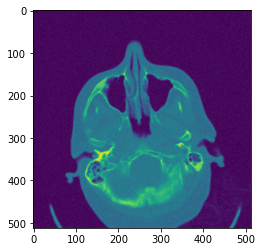

In [121]:
plt.figure()
plt.imshow(noisy_gau10)

In [101]:
vals = len(np.unique(rescaled_img))
vals = 2 ** np.ceil(np.log2(vals))

In [108]:
vals = len(np.unique(rescaled_img))
vals = 2 ** np.ceil(np.log2(vals))
# Generating noise for each unique value in image.
out = np.random.poisson(rescaled_img * vals) / float(vals)

In [133]:
dataset_list = ['train','test']

for dataset in dataset_list:
    if dataset == 'train':
        p_list = patient_train
    else:
        p_list = patient_test

    for patient in p_list:
        patient_id = patient    

        for type_ct in ["Full","Low"]:
            path_save = data_path + "/processed/" + dataset + "/" + type_ct +"/"
            Path(path_save).mkdir(parents=True, exist_ok=True)

            path_save_original = data_path + "/processed/" + dataset + "/" + type_ct +"/original/"
            path_save_gau10 = data_path + "/processed/" + dataset + "/" + type_ct +"/gau10/"
            path_save_gau50 = data_path + "/processed/" + dataset + "/" + type_ct +"/gau50/"
            path_save_poi50 = data_path + "/processed/" + dataset + "/" + type_ct +"/poi50/"
            path_save_poiimg = data_path + "/processed/" + dataset + "/" + type_ct +"/poiimg/"

            Path(path_save_original).mkdir(parents=True, exist_ok=True)
            Path(path_save_gau10).mkdir(parents=True, exist_ok=True)
            Path(path_save_gau50).mkdir(parents=True, exist_ok=True)
            Path(path_save_poi50).mkdir(parents=True, exist_ok=True)
            Path(path_save_poiimg).mkdir(parents=True, exist_ok=True)
            
            fdpath = dicom_sample_path + patient + "/*"+ type_ct + "*"

            for f in glob.iglob(fdpath): # generator, search immediate subdirectories 
               #print( patient + str(len(os.listdir(f))))
                img_files = sorted(os.listdir(f))
                middleIndex = int((len(img_files) - 1)/2) # find middle 20 images
                middle_files = img_files[(middleIndex-10):(middleIndex + 10)]
                for idx,image in enumerate(middle_files):
                    filename = f + "/" + image
                    print(filename)
                    ds = pydicom.dcmread(filename)
                    img = ds.pixel_array.astype(float)
                    rescaled_img = (np.maximum(img,0)/img.max())*255 # float pixels
                    #add noise filter and then rescale to 0-255.
                    img_org = np.uint8(rescaled_img) #integers pixels
                    img_down = np.uint8(downsample_by_averaging(img_org, (2, 2))) # 128 (4,4), 256(2,2)
                    
                    img_down = img_down[28:228,28:228]
                    img_down_arr= Image.fromarray(img_down)
                    img_down_arr.save(path_save_original + patient_id + "_pix200_" + type_ct + "_"  + str(idx + 1)  + ".png")
      

                    #gaussian(0,10)
                    gau10 = np.random.normal(0,10,img_down.shape)
                    noisy_gau10 = np.uint8(np.clip(img_down + gau10,0,255))
                    img_gau10_arr= Image.fromarray(noisy_gau10)
                    img_gau10_arr.save(path_save_gau10 + patient_id + "_pix200_" + type_ct + "_"  + str(idx + 1)  + ".png")
                    
   
                    #gaussian(0,50)
                    gau50 = np.random.normal(0,50,img_down.shape)
                    noisy_gau50 = np.uint8(np.clip(img_down + gau50,0,255))
                    img_gau50_arr= Image.fromarray(noisy_gau50)

                    img_gau50_arr.save(path_save_gau50 + patient_id + "_pix200_" + type_ct + "_"  + str(idx + 1)  + ".png")
                    
                    
                    #poisson skimage
                    vals = len(np.unique(img_down))
                    vals = 2 ** np.ceil(np.log2(vals))
                    # Generating noise for each unique value in image.
                    noisy_poiimg = np.uint8(np.clip(np.random.poisson(img_down * vals) / float(vals),0,255))
                    img_poiimg_arr= Image.fromarray(noisy_poiimg)
                    img_poiimg_arr.save(path_save_poiimg + patient_id + "_pix200_" + type_ct + "_"  + str(idx + 1)  + ".png")

                    
                    #poisson same lambda 50
                    poi50 = np.random.poisson(lam = 50, size = img_down.shape)
                    noisy_poi50 = np.uint8((np.clip(img_down + poi50,0,255)))
                    img_poi50_arr= Image.fromarray(noisy_poi50)
                    img_poi50_arr.save(path_save_poi50 + patient_id + "_pix200_" + type_ct + "_"  + str(idx + 1)  + ".png")

                    

/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N005img/1.000000-Full Dose Images-60263/1-08.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N005img/1.000000-Full Dose Images-60263/1-09.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N005img/1.000000-Full Dose Images-60263/1-10.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N005img/1.000000-Full Dose Images-60263/1-11.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N005img/1.000000-Full Dose Images-60263/1-12.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/F

/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N056img/1.000000-Full Dose Images-60654/1-18.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N056img/1.000000-Full Dose Images-60654/1-19.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N056img/1.000000-Full Dose Images-60654/1-20.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N056img/1.000000-Full Dose Images-60654/1-21.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N056img/1.000000-Full Dose Images-60654/1-22.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/F

/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N090img/1.000000-Full Dose Images-91604/1-27.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N090img/1.000000-Low Dose Images-92881/1-08.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N090img/1.000000-Low Dose Images-92881/1-09.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N090img/1.000000-Low Dose Images-92881/1-10.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N090img/1.000000-Low Dose Images-92881/1-11.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&

/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N105img/1.000000-Low Dose Images-04283/1-17.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N105img/1.000000-Low Dose Images-04283/1-18.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N105img/1.000000-Low Dose Images-04283/1-19.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N105img/1.000000-Low Dose Images-04283/1-20.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N105img/1.000000-Low Dose Images-04283/1-21.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y

/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N113img/1.000000-Low Dose Images-63687/1-27.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N113img/1.000000-Low Dose Images-63687/1-28.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N127img/1.000000-Full Dose Images-20851/1-08.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N127img/1.000000-Full Dose Images-20851/1-09.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N127img/1.000000-Full Dose Images-20851/1-10.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fal

/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N138img/1.000000-Full Dose Images-93683/1-13.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N138img/1.000000-Full Dose Images-93683/1-14.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N138img/1.000000-Full Dose Images-93683/1-15.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N138img/1.000000-Full Dose Images-93683/1-16.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N138img/1.000000-Full Dose Images-93683/1-17.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/F

/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N140img/1.000000-Low Dose Images-01446/1-11.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N140img/1.000000-Low Dose Images-01446/1-12.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N140img/1.000000-Low Dose Images-01446/1-13.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N140img/1.000000-Low Dose Images-01446/1-14.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N140img/1.000000-Low Dose Images-01446/1-15.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y

/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N141img/1.000000-Low Dose Images-64429/1-25.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N141img/1.000000-Low Dose Images-64429/1-26.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N141img/1.000000-Low Dose Images-64429/1-27.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N141img/1.000000-Low Dose Images-64429/1-28.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N153img/1.000000-Full Dose Images-16889/1-03.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&

/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N156img/1.000000-Full Dose Images-73429/1-16.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N156img/1.000000-Full Dose Images-73429/1-17.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N156img/1.000000-Full Dose Images-73429/1-18.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N156img/1.000000-Full Dose Images-73429/1-19.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N156img/1.000000-Full Dose Images-73429/1-20.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/F

/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N169img/1.000000-Full Dose Images-50494/1-29.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N169img/1.000000-Low Dose Images-10434/1-10.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N169img/1.000000-Low Dose Images-10434/1-11.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N169img/1.000000-Low Dose Images-10434/1-12.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N169img/1.000000-Low Dose Images-10434/1-13.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&

/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N177img/1.000000-Low Dose Images-84061/1-17.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N177img/1.000000-Low Dose Images-84061/1-18.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N177img/1.000000-Low Dose Images-84061/1-19.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N177img/1.000000-Low Dose Images-84061/1-20.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N177img/1.000000-Low Dose Images-84061/1-21.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y

/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N181img/1.000000-Low Dose Images-64001/1-25.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N181img/1.000000-Low Dose Images-64001/1-26.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N188img/1.000000-Full Dose Images-43217/1-08.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N188img/1.000000-Full Dose Images-43217/1-09.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N188img/1.000000-Full Dose Images-43217/1-10.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fal

/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N190img/1.000000-Full Dose Images-34193/1-16.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N190img/1.000000-Full Dose Images-34193/1-17.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N190img/1.000000-Full Dose Images-34193/1-18.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N190img/1.000000-Full Dose Images-34193/1-19.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N190img/1.000000-Full Dose Images-34193/1-20.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/F

/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N202img/1.000000-Full Dose Images-73117/1-23.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N202img/1.000000-Full Dose Images-73117/1-24.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N202img/1.000000-Full Dose Images-73117/1-25.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N202img/1.000000-Full Dose Images-73117/1-26.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N202img/1.000000-Full Dose Images-73117/1-27.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/F

/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N265img/1.000000-Low Dose Images-31380/1-11.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N265img/1.000000-Low Dose Images-31380/1-12.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N265img/1.000000-Low Dose Images-31380/1-13.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N265img/1.000000-Low Dose Images-31380/1-14.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N265img/1.000000-Low Dose Images-31380/1-15.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y

/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N279img/1.000000-Low Dose Images-23473/1-19.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N279img/1.000000-Low Dose Images-23473/1-20.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N279img/1.000000-Low Dose Images-23473/1-21.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N279img/1.000000-Low Dose Images-23473/1-22.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N279img/1.000000-Low Dose Images-23473/1-23.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y

/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N300img/1.000000-Full Dose Images-05243/1-08.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N300img/1.000000-Full Dose Images-05243/1-09.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N300img/1.000000-Full Dose Images-05243/1-10.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N300img/1.000000-Full Dose Images-05243/1-11.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N300img/1.000000-Full Dose Images-05243/1-12.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/F

/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N051img/1.000000-Full Dose Images-90849/1-15.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N051img/1.000000-Full Dose Images-90849/1-16.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N051img/1.000000-Full Dose Images-90849/1-17.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N051img/1.000000-Full Dose Images-90849/1-18.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N051img/1.000000-Full Dose Images-90849/1-19.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/F

/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N079img/1.000000-Full Dose Images-91433/1-27.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N079img/1.000000-Full Dose Images-91433/1-28.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N079img/1.000000-Low Dose Images-33316/1-09.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N079img/1.000000-Low Dose Images-33316/1-10.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N079img/1.000000-Low Dose Images-33316/1-11.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall

/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N100img/1.000000-Low Dose Images-02831/1-19.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N100img/1.000000-Low Dose Images-02831/1-20.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N100img/1.000000-Low Dose Images-02831/1-21.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N100img/1.000000-Low Dose Images-02831/1-22.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N100img/1.000000-Low Dose Images-02831/1-23.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y

/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N160img/1.000000-Full Dose Images-21061/1-07.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N160img/1.000000-Full Dose Images-21061/1-08.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N160img/1.000000-Full Dose Images-21061/1-09.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N160img/1.000000-Full Dose Images-21061/1-10.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N160img/1.000000-Full Dose Images-21061/1-11.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/F

In [200]:
for patient in patient_test:
    patient_id = patient    

    for type_ct in ["Full","Low"]:
        path_save = data_path + "/processed/test/" + type_ct +"/"
        Path(path_save).mkdir(parents=True, exist_ok=True)
        fdpath = dicom_sample_path + patient + "/*"+ type_ct + "*"
        for f in glob.iglob(fdpath): # generator, search immediate subdirectories 
           #print( patient + str(len(os.listdir(f))))
            img_files = sorted(os.listdir(f))
            middleIndex = int((len(img_files) - 1)/2) # find middle 20 images
            middle_files = img_files[(middleIndex-10):(middleIndex + 10)]
            for idx,image in enumerate(middle_files):
                filename = f + "/" + image
                print(filename)
                ds = pydicom.dcmread(filename)
                img = ds.pixel_array.astype(float)
                rescaled_img = (np.maximum(img,0)/img.max())*255 # float pixels
                img_org = np.uint8(rescaled_img) #integers pixels
                img_down = np.uint8(downsample_by_averaging(img_org, (2, 2))) # 128 (4,4), 256(2,2)
                img_down = img_down[28:228,28:228]
                #img_512= Image.fromarray(img_org)
                img_down_arr= Image.fromarray(img_down)
                img_down_arr.save(path_save + patient_id + "_pix200_" + type_ct + "_"  + str(idx +1)  + ".png")



/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N051img/1.000000-Full Dose Images-90849/1-08.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N051img/1.000000-Full Dose Images-90849/1-09.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N051img/1.000000-Full Dose Images-90849/1-10.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N051img/1.000000-Full Dose Images-90849/1-11.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N051img/1.000000-Full Dose Images-90849/1-12.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/F

/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N079img/1.000000-Full Dose Images-91433/1-20.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N079img/1.000000-Full Dose Images-91433/1-21.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N079img/1.000000-Full Dose Images-91433/1-22.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N079img/1.000000-Full Dose Images-91433/1-23.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N079img/1.000000-Full Dose Images-91433/1-24.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/F

/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N100img/1.000000-Full Dose Images-53052/1-25.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N100img/1.000000-Full Dose Images-53052/1-26.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N100img/1.000000-Low Dose Images-02831/1-07.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N100img/1.000000-Low Dose Images-02831/1-08.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N100img/1.000000-Low Dose Images-02831/1-09.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall

/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N132img/1.000000-Low Dose Images-90121/1-15.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N132img/1.000000-Low Dose Images-90121/1-16.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N132img/1.000000-Low Dose Images-90121/1-17.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N132img/1.000000-Low Dose Images-90121/1-18.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N132img/1.000000-Low Dose Images-90121/1-19.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y

/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N160img/1.000000-Low Dose Images-60221/1-25.dcm
/Users/jasperzzz/Library/CloudStorage/OneDrive-UniversityofToronto/BiostatPhD/Year1/Fall&Y_courses/CSC2529ComputImage/data/imgsamples/N160img/1.000000-Low Dose Images-60221/1-26.dcm


In [52]:
filename = f + "/" + "1-11.dcm"
#print(filename)
ds = pydicom.dcmread(filename)
img = ds.pixel_array.astype(float)
rescaled_img = (np.maximum(img,0)/img.max())*255 # float pixels


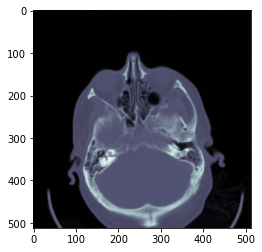

In [54]:
plt.imshow(ds.pixel_array, cmap=plt.cm.bone) 

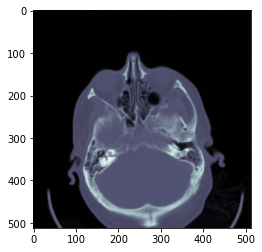

In [55]:
plt.imshow(rescaled_img, cmap=plt.cm.bone) 

In [56]:

img_org = np.uint8(rescaled_img) #integers pixels
img_down = np.uint8(downsample_by_averaging(img_org, (4, 4)))

img_512= Image.fromarray(img_org)
img_128= Image.fromarray(img_down)
#img_512.save(path_save + patient_id + "_" + type_ct +"_img512_" + image[0:-3] + ".jpg")
#img_128.save(path_save + patient_id + "_" + type_ct +"_img128_" + image[0:-3] + ".jpg")

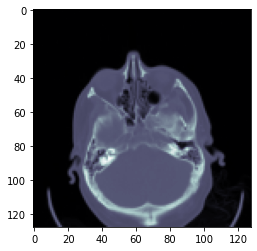

In [58]:
plt.imshow(img_128, cmap=plt.cm.bone) 